# <center>Skin Cancer Detection <br> using Convolutional Neural Networks (CNNs)</center>

## **Introduction**

In this notebook, we develop and train a Convolutional Neural Network (CNN) for skin cancer detection, specifically using the **melanoma** dataset. The primary goal is to build a model that can accurately classify skin lesions as either malignant or benign based on images. This is a crucial step in automating skin cancer detection, assisting healthcare professionals in diagnosing melanoma at an early stage.

### 🌐 **Follow Me on Social Media:**  

- [![LinkedIn](https://img.shields.io/badge/LinkedIn-Connect-blue?style=flat&logo=linkedin)](https://linkedin.com/in/codewithdark)  
- [![GitHub](https://img.shields.io/badge/GitHub-Follow-black?style=flat&logo=github)](https://github.com/codewithdark-git/Melanoma-Skin-Cancer-CNN.git)  
- [![Kaggle](https://img.shields.io/badge/Kaggle-Follow-blue?style=flat&logo=kaggle)](https://kaggle.com/codewithdark)  
- [![See Notebook](https://img.shields.io/badge/Kaggle-View%20Notebooks-blue?style=flat&logo=kaggle)](https://www.kaggle.com/code/codewithdark/pre-train-custom-cnn-models-for-skin-cancer)  
- [![See Blog Post](https://img.shields.io/badge/Read-Blog%20Post-blue?style=flat&logo=readme)](https://gist.github.com/codewithdark-git/)  
- [![Email Me](https://img.shields.io/badge/Email-Contact%20Me-orange?style=flat&logo=gmail)](mailto:codewithdark90@gmail.com)


### **Steps Involved:**
1. **Data Preparation**: We'll begin by loading and preprocessing the image dataset, applying transformations to prepare the data for training.
2. **Model Building**: We'll implement a CNN architecture suitable for image classification, leveraging layers such as convolution, pooling, and fully connected layers.
3. **Training the Model**: The model will be trained using the dataset, and we will optimize the model for accuracy.
4. **Evaluation**: We'll assess the model's performance on test data using metrics like accuracy and confusion matrices.
5. **Visualization**: We will use tools like Grad-CAM to visualize which parts of the images the model is focusing on to make predictions.

This notebook serves as a practical example of applying deep learning techniques to medical image classification, focusing on skin cancer detection using CNNs.

### **Note:**
I’m currently in the process of learning, so if you notice areas where improvements can be made, feel free to reach out and share your insights. Collaborating to fix issues or enhance the implementation will help us all grow!


In [5]:
import warnings
warnings.resetwarnings()

In [ ]:
%pip install pandas numpy torch torchvision torchviz matplotlib opencv-python tqdm

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
from torchvision import transforms, models
import cv2
import torch
from torchviz import make_dot
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from pathlib import Path
from typing import List, Tuple, Dict
from tqdm import tqdm
import logging

This command downloads the **Melanoma Skin Cancer Dataset** from Kaggle. The dataset is hosted under the username `hasnainjaved` and contains **10,000 images** for melanoma skin cancer classification.

. **Extract the Dataset:**
   ```bash
   unzip melanoma-skin-cancer-dataset-of-10000-images.zip
   ```



In [3]:
!kaggle datasets download hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
 84%|████████████████████████████████▊      | 83.0M/98.7M [00:00<00:00, 100MB/s]
100%|███████████████████████████████████████| 98.7M/98.7M [00:00<00:00, 121MB/s]


### seed
This sets the seed for generating random numbers in PyTorch, ensuring reproducibility of results. The number `42` is the seed value. Once set, PyTorch's random number generators produce the same sequence of numbers each time the code is run.

---

#### **Why Set a Seed?**

Randomness is used extensively in machine learning for tasks like:
1. Weight initialization in neural networks.
2. Data augmentation (e.g., random cropping, flipping, or rotations).
3. Shuffling of datasets during training.
4. Sampling during optimization or probabilistic modeling.

By setting a seed:
- You **control randomness**, making experiments reproducible.
- You **debug models** more effectively by ensuring the same inputs lead to the same outputs.

#### **Further Reading**
- [PyTorch Manual Seed Documentation](https://pytorch.org/docs/stable/generated/torch.manual_seed.html)
- [Reproducibility in PyTorch](https://pytorch.org/docs/stable/notes/randomness.html)


In [4]:
torch.manual_seed(42)

### Unzip data
This script extracts a specified `.zip` file to a target directory.

#### **Steps:**
1. Sets the path to the zip file (`zip_file_path`) and the extraction directory (`extract_to_path`).
2. Ensures the target directory exists by creating it if it doesn't.
3. Uses Python's `zipfile` module to extract all files from the zip archive to the specified directory.
4. Prints a success message with the target directory.

#### **Usage Example:**
Run this script to extract the file `melanoma-skin-cancer-dataset-of-10000-images.zip` into the current directory (`.`).

---

#### **Further Reading:**
- [Python `zipfile` Documentation](https://docs.python.org/3/library/zipfile.html)
- [Python `os` Module Documentation](https://docs.python.org/3/library/os.html)


In [5]:


# Specify the path to the zip file
zip_file_path = 'melanoma-skin-cancer-dataset-of-10000-images.zip'
extract_to_path = '.'

# Create the directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to {extract_to_path}")

Files extracted to .


### **Melanoma Data Processor**

#### **Purpose:**
The script processes a melanoma skin cancer image dataset by resizing, labeling, and preparing it for machine learning tasks.

---

#### **Key Functionalities:**

1. **Class `MelanomaDataProcessor`:**
   - **Attributes:**
     - `img_size`: Resizes all images to a specified square dimension (default: `50`).
   - **Methods:**
     - `load_and_process_image(image_path)`: Loads an image, converts it to grayscale, and resizes it.
     - `process_directory(directory, label)`: Processes all images in a directory and assigns the specified label.
     - `process_dataset(data_config)`: Processes training and testing datasets, balances samples, and shuffles them.

2. **Logging Setup:**
   - Logs processing progress and errors to both the console and a log file (`melanoma_processing.log`).

3. **Main Script:**
   - Defines directory paths in `data_config`.
   - Initializes the processor and prepares data.
   - Saves the preprocessed dataset in compressed `.npz` format.

---

#### **Usage:**
Run the script to process the melanoma dataset and generate `melanoma_dataset.npz`, which contains:
- `train_images`, `train_labels`
- `test_images`, `test_labels`

---

#### **Output:**
- Processed images resized to `224x224`.
- Labels:
  - Benign: `[1, 0]`
  - Malignant: `[0, 1]`
- A compressed `.npz` file ready for machine learning workflows.


In [6]:
class MelanomaDataProcessor:
    def __init__(self, img_size: int = 50):
        self.img_size = img_size
        self.setup_logging()

    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler('melanoma_processing.log'),
                logging.StreamHandler()
            ]
        )

    def load_and_process_image(self, image_path: str) -> np.ndarray:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to load image: {image_path}")

        return cv2.resize(img, (self.img_size, self.img_size))

    def process_directory(self, directory: str, label: np.ndarray) -> Tuple[List, List]:
        """
        Process all images in a directory.

        Returns:
            Tuple of (images, labels)
        """
        images = []
        labels = []
        directory_path = Path(directory)

        if not directory_path.exists():
            logging.error(f"Directory not found: {directory}")
            return images, labels

        files = list(directory_path.glob('*.jpg')) + list(directory_path.glob('*.png'))

        for file_path in tqdm(files, desc=f"Processing {directory_path.name}"):
            try:
                img_array = self.load_and_process_image(str(file_path))
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                logging.warning(f"Error processing {file_path}: {str(e)}")

        return images, labels

    def process_dataset(self, data_config: Dict) -> Tuple[Tuple[np.ndarray, np.ndarray],
                                                         Tuple[np.ndarray, np.ndarray]]:
        """
        Process the entire dataset.

        Returns:
            Tuple of ((train_images, train_labels), (test_images, test_labels))
        """
        # Process training data
        ben_train_images, ben_train_labels = self.process_directory(
            data_config['ben_training_folder'],
            np.array([1, 0])
        )
        mal_train_images, mal_train_labels = self.process_directory(
            data_config['mal_training_folder'],
            np.array([0, 1])
        )

        # Balance benign training data
        ben_train_images = ben_train_images[:len(mal_train_images)]
        ben_train_labels = ben_train_labels[:len(mal_train_labels)]

        # Process testing data
        ben_test_images, ben_test_labels = self.process_directory(
            data_config['ben_testing_folder'],
            np.array([1, 0])
        )
        mal_test_images, mal_test_labels = self.process_directory(
            data_config['mal_testing_folder'],
            np.array([0, 1])
        )

        # Combine images and labels
        train_images = np.array(ben_train_images + mal_train_images)
        train_labels = np.array(ben_train_labels + mal_train_labels)
        test_images = np.array(ben_test_images + mal_test_images)
        test_labels = np.array(ben_test_labels + mal_test_labels)

        # Create shuffling index
        train_shuffle_idx = np.random.permutation(len(train_images))
        test_shuffle_idx = np.random.permutation(len(test_images))

        # Shuffle both images and labels using the same index
        train_images = train_images[train_shuffle_idx]
        train_labels = train_labels[train_shuffle_idx]
        test_images = test_images[test_shuffle_idx]
        test_labels = test_labels[test_shuffle_idx]

        # Log dataset statistics
        self.log_dataset_stats(
            len(ben_train_images),
            len(mal_train_images),
            len(ben_test_images),
            len(mal_test_images)
        )

        return (train_images, train_labels), (test_images, test_labels)

    def log_dataset_stats(self, ben_train: int, mal_train: int,
                         ben_test: int, mal_test: int):
        logging.info("\nDataset Statistics:")
        logging.info(f"Benign training samples: {ben_train}")
        logging.info(f"Malignant training samples: {mal_train}")
        logging.info(f"Benign testing samples: {ben_test}")
        logging.info(f"Malignant testing samples: {mal_test}")
        logging.info(f"Total training samples: {ben_train + mal_train}")
        logging.info(f"Total testing samples: {ben_test + mal_test}")

def main():
    # Configuration
    data_config = {
        'ben_training_folder': "melanoma_cancer_dataset/train/benign",
        'mal_training_folder': "melanoma_cancer_dataset/train/malignant",
        'ben_testing_folder': "melanoma_cancer_dataset/test/benign",
        'mal_testing_folder': "melanoma_cancer_dataset/test/malignant",
    }

    # Initialize and run processor
    processor = MelanomaDataProcessor(img_size=224)
    (train_images, train_labels), (test_images, test_labels) = processor.process_dataset(data_config)

    # Save processed data
    np.savez_compressed(
        'melanoma_dataset.npz',
        train_images=train_images,
        train_labels=train_labels,
        test_images=test_images,
        test_labels=test_labels
    )

if __name__ == "__main__":
    main()

Processing malignant: 100%|██████████| 500/500 [00:00<00:00, 2525.54it/s]


### **Check Device**
  
This code checks if a GPU (CUDA) is available and sets the PyTorch device accordingly. If a GPU is available, it uses `"cuda"` for computation; otherwise, it falls back to the CPU (`"cpu"`). The `device` variable is used to move tensors and models to the selected hardware.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Torch Custom Dataset**

#### **Purpose:**
This script defines a custom PyTorch `Dataset` class to load data directly from NumPy arrays, with optional transformations applied to the features.

---

### **Key Components:**

#### **Class `NumpyDataset`:**
A dataset class inheriting from `torch.utils.data.Dataset`.

- **Attributes:**
  - `data`: NumPy array of features (e.g., images).
  - `labels`: NumPy array of labels.
  - `transform`: Callable transformations applied to features.

- **Methods:**
  1. **`__init__(self, data, labels, transform=None)`**
     - Initializes the dataset with features, labels, and optional transformations.
  2. **`__len__(self)`**
     - Returns the total number of samples in the dataset.
  3. **`__getitem__(self, idx)`**
     - Retrieves a single sample (feature and label) at the specified index.
     - Converts features to PIL images for compatibility with `torchvision.transforms`.
     - Applies transformations (if provided).
     - Converts labels to PyTorch tensors.

---


#### **Important Notes:**
1. **Feature Conversion:**
   - Images are converted from NumPy arrays to PIL images using `Image.fromarray`.
   - The conversion ensures compatibility with `torchvision.transforms`.

2. **Transformations:**
   - Can include resizing, normalization, data augmentation, etc.
   - Applied only to features (not labels).

3. **Label Conversion:**
   - Labels are converted to PyTorch tensors with `dtype=torch.float` for flexibility in loss functions.

4. **Device Assignment:**
   - The `label` is moved to the same `device` as the model (e.g., CPU or GPU).

---

#### **Output:**
A PyTorch `Dataset` that works seamlessly with `DataLoader`, enabling batching, shuffling, and parallel data loading.


In [10]:
class NumpyDataset(Dataset):
    """
    Custom Dataset to load data directly from NumPy arrays with transformations.
    """
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy.ndarray): Feature data (e.g., images) as a NumPy array.
            labels (numpy.ndarray): Labels as a NumPy array.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the feature and label
        feature = self.data[idx]
        label = self.labels[idx]

        # Convert the feature (image) to a PIL image
        feature = Image.fromarray((feature.squeeze() * 255).astype(np.uint8))  # Squeeze if single channel

        # If transforms are provided, apply them to the feature
        if self.transform:
            feature = self.transform(feature)

        # Convert the label to a PyTorch tensor
        
        label = torch.tensor(label, dtype=torch.float, device=device)
        

        return feature, label

### **Dataset and Dataloder**

#### **Purpose:**
This script loads a preprocessed melanoma dataset stored in a `.npz` file, applies transformations to the images, and prepares DataLoaders for both training and testing data to facilitate batching and shuffling during training.

---

### **Key Steps:**

1. **Load Dataset:**
   - The dataset is loaded using `np.load`, which extracts the training and testing images (`train_images`, `test_images`) and their corresponding labels (`train_labels`, `test_labels`).

2. **Define Transformations:**
   - Preprocessing steps are applied using `torchvision.transforms` to standardize image size, format, and normalization.

3. **Create Custom Dataset and DataLoaders:**
   - `NumpyDataset`: A custom dataset class is instantiated with transformations applied to the data.
   - `DataLoader`: Wraps the datasets for batching, shuffling, and easy iteration.

4. **Test DataLoaders:**
   - A single batch of images and labels is retrieved to confirm the correct shapes and processing.


---

### **Explanation of Transformations:**
1. **`Resize((224, 224))`:**
   - Resizes all images to a fixed size of 224x224 pixels for model compatibility.

2. **`Grayscale(num_output_channels=1)`:**
   - Ensures images are single-channel grayscale, even if originally RGB or other formats.

3. **`ToTensor()`:**
   - Converts the image data to PyTorch tensors and scales pixel values from `[0, 255]` to `[0, 1]`.

4. **`Normalize(mean=[0.485], std=[0.229])`:**
   - Normalizes grayscale images using the specified mean and standard deviation for standardized input values.

---

### **Expected Output:**
- **Training DataLoader Batch Shapes:**
  - Images: `(16, 1, 224, 224)`
  - Labels: `(16,2)`

- **Testing DataLoader Batch Shapes:**
  - Images: `(16, 1, 224, 224)`
  - Labels: `(16,2)`

---

### **Usage Notes:**
- Ensure the `.npz` file is correctly loaded and contains the specified keys (`train_images`, `train_labels`, `test_images`, `test_labels`).
- The `shuffle=True` parameter randomizes the order of data batches for improved training performance.

Let me know if further clarifications or additions are needed! 🚀

In [74]:
# Load your dataset
data = np.load('/kaggle/working/melanoma_dataset.npz')
train_images = data['train_images']  # Shape: (num_samples, 224, 224) or (num_samples, 1, 224, 224)
train_labels = data['train_labels']
test_images = data['test_images']
test_labels = data['test_labels']

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Adjust normalization for grayscale
])

# Create Dataset and DataLoader
dataset = NumpyDataset(train_images, train_labels, transform=transform)
trainloader = DataLoader(dataset, batch_size=16, shuffle=True)

dataset_test = NumpyDataset(test_images, test_labels, transform=transform)
testloader = DataLoader(dataset_test, batch_size=16, shuffle=True)

# Test the DataLoader
for images, labels in trainloader:
    print(f"Batch images shape: {images.shape}")  # Should be (batch_size, 1, 224, 224)
    print(f"Batch labels shape: {labels.shape}")  # Should be (batch_size,)
    break

for images, labels in testloader:
    print(f"Batch images shape: {images.shape}")  # Should be (batch_size, 1, 224, 224)
    print(f"Batch labels shape: {labels.shape}")  # Should be (batch_size,)
    break

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Batch images shape: torch.Size([16, 1, 224, 224])
Batch labels shape: torch.Size([16, 2])
Batch images shape: torch.Size([16, 1, 224, 224])
Batch labels shape: torch.Size([16, 2])


### **Pre-train Model**

#### **Purpose:**
This code initializes a pre-trained ResNet-18 model, customizes it for grayscale input and binary classification, and prepares it to run on the appropriate device (CPU or GPU).

---

### **Steps in the Code:**

1. **Load Pre-trained ResNet-18:**
   - The `models.resnet18(weights=models.ResNet18_Weights.DEFAULT)` initializes a ResNet-18 model with pre-trained weights from ImageNet.

2. **Modify the First Convolutional Layer:**
   - The first convolutional layer (`conv1`) is updated to accept a single-channel grayscale input instead of the default 3-channel RGB input. 
     - **Old Dimensions:** `(in_channels=3, out_channels=64, kernel_size=(7, 7))`
     - **New Dimensions:** `(in_channels=1, out_channels=64, kernel_size=(7, 7))`

3. **Update the Fully Connected Layer:**
   - The final fully connected layer (`fc`) is modified to output 2 classes for binary classification.
     - **Old Dimensions:** `in_features -> 1000 (default for ImageNet)`
     - **New Dimensions:** `in_features -> 2` (for binary classification)

4. **Device Setup:**
   - The model is moved to the appropriate computation device (`cuda` for GPU or `cpu`).

)


### **Explanations:**

#### 1. **ResNet-18:**
   - ResNet-18 is a convolutional neural network with 18 layers designed for image classification tasks.
   - Pre-trained weights allow transfer learning, leveraging learned features from ImageNet for new tasks.

#### 2. **First Convolutional Layer Modification:**
   - Default ResNet-18 is trained on 3-channel RGB images. Grayscale images have only 1 channel, so `conv1` is adjusted accordingly:
     ```python
     model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     ```

#### 3. **Fully Connected Layer Adjustment:**
   - For binary classification (e.g., benign vs. malignant melanoma), the output dimension of the final layer (`fc`) is changed to 2:
     ```python
     model.fc = nn.Linear(model.fc.in_features, 2)
     ```

#### 4. **Device Selection:**
   - The model is sent to a GPU if available; otherwise, it defaults to the CPU:
     ```python
     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     model = model.to(device)
     ```

---

### **Use Case:**
- This modified ResNet-18 model is suitable for grayscale image input (e.g., melanoma images).
- With binary classification output, it can distinguish between two classes, such as benign and malignant cases.


In [14]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the first convolutional layer to accept 1 channel (grayscale)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Optionally, adjust the final fully connected layer if needed (for binary classification)
model.fc = nn.Linear(model.fc.in_features, 2)  # For binary classification (adjust based on your use case)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s] 


### **Parameter Loss Function and Optimizer**

#### **Purpose:**
This part of the code defines the loss function and the optimizer for training the neural network model (ResNet-18 in this case) on a classification task.

---

### **Steps in the Code:**

1. **Loss Function:**
   - **`nn.CrossEntropyLoss()`** is used as the loss function, which is commonly used for classification tasks. It computes the cross-entropy loss between the predicted and target class labels.

2. **Optimizer:**
   - **`optim.Adam(model.parameters(), lr=0.001)`** initializes the Adam optimizer to update the model's parameters during training. The learning rate is set to `0.001`.

### **Explanations:**

#### 1. **Cross-Entropy Loss:**
   - **Formula:** 
     $$
     \text{Cross-Entropy Loss} = - \sum_{i=1}^{N} y_i \log(\hat{y}_i)
     $$
     where:
     - $( y_i )$ is the true label (one-hot encoded),
     - $( \hat{y}_i )$ is the predicted probability for class $( i )$,
     - $( N )$ is the number of classes.
   - In binary classification, this function computes the loss based on the log-likelihood of the correct class.

   - This function is ideal for multi-class classification tasks like melanoma detection (benign vs. malignant).

#### 2. **Optimizer (Adam):**
   - **Adam (Adaptive Moment Estimation)** is an optimization algorithm that combines the benefits of both **AdaGrad** and **RMSProp**. It adjusts the learning rate based on the gradients' first and second moments.
   - **Formula for Adam Update:**
     $$
     \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{v_t} + \epsilon} \cdot m_t
     $$
     where:
     - $( \theta_t )$ is the model parameter at time $( t )$,
     - $(m_t)$ and $(v_t)$ are the first and second moment estimates,
     - $(\eta )$ is the learning rate,
     - $( \epsilon )$ is a small constant to avoid division by zero.

   - Adam is widely used due to its efficiency in training deep learning models with relatively less tuning required.

#### 3. **Learning Rate:**
   - The learning rate of `0.001` is a common default for Adam. It determines the size of the step taken in the optimization process. A larger learning rate might lead to instability, while a smaller one might make training slower.

---

### **Use Case:**
- **Loss Function:** Cross-entropy loss is suitable for training classification models where the goal is to predict a class label.
- **Optimizer:** Adam is widely used in deep learning, particularly in tasks with large datasets and complex models like ResNet-18.


In [16]:
# Loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.001)


### **Training Loop**

#### **Purpose:**
This part of the code implements the **training loop** for a deep learning model (ResNet-18) on the melanoma dataset. The loop runs for a set number of epochs, performing forward and backward passes, updating the model's parameters, and tracking the loss and accuracy at each epoch.

---

### **Steps in the Code:**

1. **Epoch Loop:**
   - **`for epoch in range(num_epochs):`** initiates the loop for training over `num_epochs` (10 in this case).
   - In each epoch, the model is set to training mode (`model.train()`), and various metrics (like loss, accuracy) are tracked.
   
2. **Mini-batch Loop:**
   - For each mini-batch of data in the `trainloader`, the following steps are executed:
     - **Data Transfer to Device:** 
       - `inputs, labels = inputs.to(device), labels.to(device)` moves the input data and labels to the available device (GPU or CPU).
     - **Zero the Gradients:** 
       - `optimizer.zero_grad()` clears the previous gradients to prevent them from accumulating.
     - **Forward Pass:** 
       - `outputs = model(inputs)` feeds the inputs into the model to get the predicted outputs.
     - **Loss Calculation:** 
       - The loss is calculated using the `criterion` (cross-entropy loss).
     - **Backward Pass:** 
       - `loss.backward()` computes the gradients.
     - **Optimization Step:** 
       - `optimizer.step()` updates the model parameters based on the computed gradients.
     - **Accuracy Calculation:** 
       - The accuracy is tracked by comparing the predicted class labels to the actual ones.

3. **Loss and Accuracy Reporting:**
   - At the end of each epoch, the average loss and accuracy are computed and printed.

---

### **Explanations:**

#### 1. **Epoch Loop:**
   - **Purpose:** The loop runs for `num_epochs` (in this case, 10 epochs), performing training on the dataset. Each epoch corresponds to one complete pass through the training data.

#### 2. **Mini-batch Processing:**
   - **`inputs.to(device), labels.to(device)`**: Transfers the input data and labels to the device (either GPU or CPU). This is necessary when training on a GPU.
   - **`optimizer.zero_grad()`**: Clears old gradients before computing the new gradients.
   - **`model(inputs)`**: Passes the input data through the model to obtain predictions (`outputs`).
   - **`loss.backward()`**: Computes gradients for the model parameters based on the loss.
   - **`optimizer.step()`**: Updates the model parameters based on the gradients.

#### 3. **Accuracy Calculation:**
   - **`torch.max(outputs, dim=1)`**: This gets the index of the highest value in the output tensor, which corresponds to the predicted class. The `dim=1` ensures that the maximum value is selected for each example (across classes).
   - **`labels = torch.argmax(labels, dim=1)`**: Since the labels are one-hot encoded, `torch.argmax()` converts them back to class indices.
   - **`correct += (predicted == labels).sum().item()`**: This counts how many predictions match the actual labels.
   - **`total += labels.size(0)`**: This keeps track of the total number of examples processed.

#### 4. **Loss and Accuracy Reporting:**
   - At the end of each epoch, the average loss and accuracy for the epoch are computed and printed:
     - **Loss** is averaged over all mini-batches.
     - **Accuracy** is the percentage of correct predictions out of the total predictions.

---

### **Mathematical Formulas:**

1. **Cross-Entropy Loss:**
   $$
   L = - \sum_{i=1}^{N} y_i \log(\hat{y}_i)
   $$
   where:
   - $( y_i )$ is the true class label (one-hot encoded),
   - $( \hat{y}_i )$ is the predicted probability for class ( i ),
   - $( N )$ is the number of classes.

2. **Accuracy:**
   $$
   \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}} \times 100
   $$


In [17]:
num_epochs = 10  # Set the number of epochs

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(outputs, dim=1)
        # predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    # Print the loss and accuracy at the end of each epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch 1/10, Loss: 0.3597, Accuracy: 84.22%
Epoch 2/10, Loss: 0.3072, Accuracy: 87.30%
Epoch 3/10, Loss: 0.2746, Accuracy: 88.68%
Epoch 4/10, Loss: 0.2676, Accuracy: 89.16%
Epoch 5/10, Loss: 0.2358, Accuracy: 90.84%
Epoch 6/10, Loss: 0.2306, Accuracy: 90.65%
Epoch 7/10, Loss: 0.2173, Accuracy: 91.42%
Epoch 8/10, Loss: 0.2066, Accuracy: 92.21%
Epoch 9/10, Loss: 0.1949, Accuracy: 92.32%
Epoch 10/10, Loss: 0.1787, Accuracy: 93.28%


### **Validation Phase**

#### **Purpose:**
This section of the code is used to evaluate the performance of the trained model on the validation (or test) dataset. It computes the **accuracy** of the model on unseen data and can be extended to include additional evaluation metrics such as confusion matrix, precision, recall, and F1-score.

---

### **Steps in the Code:**

1. **Switch Model to Evaluation Mode:**
   - **`model.eval()`**: This sets the model to evaluation mode, which disables features like dropout layers and batch normalization updates that are used during training. This is important to ensure that the model behaves differently during inference (evaluation) compared to training.

2. **Disable Gradient Computation:**
   - **`with torch.no_grad():`**: This ensures that no gradients are computed during the validation phase. This is done because gradients are not required for evaluation, saving memory and computation time.

3. **Validation Loop:**
   - For each batch in the test set (`testloader`), the following operations are performed:
     - **Data Transfer to Device:**
       - `inputs, labels = inputs.to(device), labels.to(device)` moves the input data and labels to the available device (GPU or CPU).
     - **Forward Pass:**
       - `outputs = model(inputs)` feeds the inputs through the trained model to obtain predictions (`outputs`).
     - **Predictions:**
       - `_, predicted = torch.max(outputs, dim=1)` gives the predicted class by selecting the class with the highest output probability.
     - **Label Conversion:**
       - `labels = torch.argmax(labels, dim=1)` converts one-hot encoded labels to class indices.
     - **Accuracy Calculation:**
       - **`val_correct += (predicted == labels).sum().item()`** counts how many predictions match the true labels.
       - **`val_total += labels.size(0)`** keeps track of the total number of samples in the test set.

4. **Compute and Display Accuracy:**
   - **`val_accuracy = 100 * val_correct / val_total`** computes the accuracy of the model on the test set.
   - The accuracy is printed to the console.


### **Mathematical Formula:**
- **Accuracy:**
   $$
   \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}} \times 100
   $$


In [75]:
# Switch model to evaluation mode
model.eval()
val_correct = 0
val_total = 0
val_preds = []
val_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)

        labels = torch.argmax(labels, dim=1)
        
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Optionally, calculate other metrics like confusion matrix, F1-score, etc.


Validation Accuracy: 90.20%


In [19]:
torch.save(model.state_dict(), "skin_cancer_model.pth")


### **Visualizing Test Images and Predictions**

#### **Purpose:**
This code is used to visualize some test images and display the predictions made by the trained model on these images. The images are shown in a grid format, and the corresponding predicted labels are printed.

---

### **Explanation:**

1. **`imshow(img)`**:
   - This function takes an image tensor `img` as input and displays it using `matplotlib`. 
   - The image tensor is typically normalized, so we reverse the normalization by performing `img / 2 + 0.5` to scale it back to the original range (from `[0, 1]`).
   - `np.transpose(npimg, (1, 2, 0))` is used to change the shape of the tensor for display because `imshow` requires the image to be in the format `(height, width, channels)`.

2. **`model.eval()`**:
   - This sets the model in evaluation mode. In this mode, layers like dropout and batch normalization, which behave differently during training and testing, will now behave correctly for testing.

3. **`dataiter = iter(testloader)`**:
   - Creates an iterator over the `testloader` DataLoader object, which contains the test dataset in batches.

4. **`images, labels = next(dataiter)`**:
   - Fetches a batch of images and their corresponding labels from the test DataLoader. `next(dataiter)` returns the next batch of data.

5. **`imshow(torchvision.utils.make_grid(images))`**:
   - This function from `torchvision.utils` arranges the images in the batch into a grid and then calls the `imshow` function to display it.
   - The images in the batch are visualized together, making it easier to inspect multiple samples at once.

6. **`outputs = model(images.to(device))`**:
   - The batch of images is passed through the model to generate predictions. The images are moved to the correct device (`GPU/CPU`) for inference.
   
7. **`_, predicted = torch.max(outputs, 1)`**:
   - `torch.max(outputs, 1)` returns the maximum values in the prediction tensor for each image, along with their corresponding indices. The indices represent the predicted class labels.
   - The second element `predicted` contains the predicted class labels (in this case, binary labels).

8. **`print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(8)))`**:
   - This prints the predicted class labels for the first 8 images in the batch. It joins the predicted values into a string for display.

---

### **Mathematical Formulas or Concepts:**

- **Image Normalization**:
  The images are typically normalized when passed through the model, meaning their pixel values are scaled to a range like `[0, 1]`. When visualizing the images, we reverse this normalization to bring the image values back to the standard `[0, 255]` range for display.
  
  Formula:  
  \[
  \text{unnormalized\_img} = \frac{\text{img}}{2} + 0.5
  \]
  
- **Prediction (using `torch.max`)**:
  The `torch.max()` function returns the highest value in the output tensor and the index corresponding to it. In the context of classification, the index represents the predicted class.

  Formula:
  \[
  \text{predicted\_label} = \arg\max(\text{outputs})
  \]


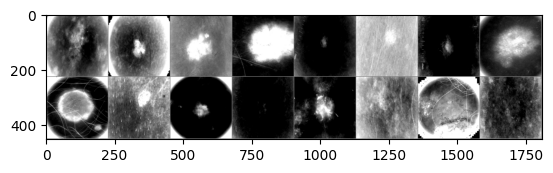

Predicted:  1 1 0 1 0 0 0 1


In [23]:


def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Visualize some test images and their predictions
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Make predictions
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(8)))


### **custom Convolutional Neural Network (CNN):**

This code defines a custom Convolutional Neural Network (CNN) for melanoma classification, leveraging both custom convolutional layers and the option to use a pretrained model (ResNet18). The network structure also supports advanced features like Batch Normalization, Dropout, and Global Average Pooling.

Here’s a breakdown of the key components:

---

### **Class `MelanomaCNN(nn.Module)`**

1. **`__init__(self, pretrained=False)`**:
   - The constructor initializes the layers of the network.
   - **Pretrained Model Option**: If `pretrained=True`, the network uses the ResNet18 model pretrained on ImageNet. The fully connected (FC) layer is replaced to output 2 classes (melanoma or not).
   - **Custom CNN Architecture**: If `pretrained=False`, a custom CNN architecture is defined:
     - **Conv1, Conv2, Conv3**: These are convolutional layers with increasing filter sizes (32, 64, 128 filters), each followed by Batch Normalization (`bn1`, `bn2`, `bn3`) and a ReLU activation function.
     - **Global Average Pooling**: This layer reduces the spatial dimensions to `(1, 1)` for the feature map, resulting in a single value per feature channel.
     - **Fully Connected Layers (fc1, fc2)**: After flattening the pooled features, the network passes them through fully connected layers. A dropout layer is applied after the first fully connected layer to prevent overfitting.

2. **`forward(self, x)`**:
   - This method defines the forward pass of the network.
   - If a pretrained model is used (`self.resnet` is defined), the input is passed directly through the ResNet18 model.
   - For the custom CNN path, the input is processed through three convolutional blocks, followed by global average pooling, and then passed through the fully connected layers to output logits (before applying softmax).

3. **`get_feature_dims(self, input_size=(1, 224, 224))`**:
   - This method computes the feature dimensions at each layer of the network for debugging purposes.
   - A dummy input tensor of shape `(1, 224, 224)` is passed through the network, and the output shape at each layer (after each convolution and pooling operation) is stored in the `dims` dictionary.
   - This method is useful for inspecting how the input dimensions change throughout the network.

---

### **Network Features**:

- **Convolutional Layers**: `conv1`, `conv2`, `conv3`—each with increasing filters and followed by Batch Normalization. The convolution operations extract features from the input image.
- **Activation Function**: ReLU is used after each convolution and fully connected layer to introduce non-linearity.
- **Pooling**: Max Pooling is applied after each convolutional block to reduce spatial dimensions.
- **Global Average Pooling**: Reduces the spatial dimensions to `1x1`, retaining only one value per channel. This helps in reducing overfitting by preventing the model from memorizing the spatial features.
- **Fully Connected Layers**: The final layers (`fc1`, `fc2`) provide the model’s final output: two classes for binary classification (melanoma or non-melanoma).
- **Dropout**: Dropout is applied after the first fully connected layer to regularize the model and prevent overfitting.


### **1. Convolutional Layers:**   

- **Conv1**: 
  $$
  \text{Output} = \text{Conv}(I, W_1) + b_1
  $$  
  Where:
  - $( I )$ is the input image with dimensions $((H, W, 1)) (height, width, channels)$.
  - $( W_1 )$ is the filter (kernel) of size $(3 \times 3)$ and $(32)$ filters.
  - $( b_1 )$ is the bias.
  - The convolution operation is followed by a **ReLU activation** function:
  $$
  \text{Output} = \text{ReLU}(\text{Conv}(I, W_1) + b_1)
  $$

- **Conv2**: 
  $$
  \text{Output} = \text{Conv}(\text{Output from Conv1}, W_2) + b_2
  $$
  Where:
  - $( W_2 )$ is the filter of size $(3 \times 3)$ and $(64)$ filters.
  - The output undergoes **Batch Normalization** and **ReLU activation**:
  $$
  \text{Output} = \text{ReLU}(\text{BatchNorm}(\text{Conv}(I, W_2) + b_2))
  $$

- **Conv3**: 
  $$
  \text{Output} = \text{Conv}(\text{Output from Conv2}, W_3) + b_3
  $$
  Where:
  - $( W_3 )$ is the filter of size $(3 \times 3)$ and $(128)$ filters.
  - Again, followed by **Batch Normalization** and **ReLU activation**.

---

### **2. Pooling:**

- After each convolutional block, we apply **Max Pooling** with kernel size \(2 \times 2\) to reduce the spatial dimensions.
  $$
  \text{Output after pooling} = \text{MaxPool}(\text{Conv}(\text{Input}, W_n) + b_n)
  $$
  Where $(n = 1, 2, 3)$.

---

### **3. Global Average Pooling:**

- After the convolutional layers and pooling, the output dimensions are reduced by **Global Average Pooling** (GAP), which computes the average over each feature map:
  $$
  \text{GAP Output} = \frac{1}{H \times W} \sum_{i=1}^{H} \sum_{j=1}^{W} x_{i,j}
  $$
  Where:
  - $(H)$ and $(W)$ are the height and width of the feature map.
  - $(x_{i,j})$ is the feature at position $(i,j)$.
  - This reduces the output to a single value per feature map.

---

### **4. Fully Connected Layers:**

- After GAP, the resulting vector is flattened to a 1D vector:
  $$
  \text{Flattened Output} = \text{Flatten}(\text{GAP Output})
  $$

- **FC1**: 
  $$
  \text{Output} = W_4 \cdot \text{Flattened Output} + b_4
  $$
  Where:
  - $(W_4)$ is the weight matrix for the fully connected layer, and $( b_4)$ is the bias.
  - A **ReLU activation** is applied to the output of FC1:
  $$
  \text{Output} = \text{ReLU}(W_4 \cdot \text{Flattened Output} + b_4)
  $$

- **Dropout**: 
  $$
  \text{Output after dropout} = \text{Dropout}(\text{Output of FC1})
  $$

- **FC2** (Final Layer): 
  $$
  \text{Output} = W_5 \cdot \text{Output after Dropout} + b_5
  $$
  Where:
  - $( W_5) is the weight matrix for the final fully connected layer.
  - This layer outputs the raw logits for the two classes (melanoma or not melanoma).

---

### **5. Final Output (Logits)**:

- The model’s final output is a vector of size \(2\), representing the raw logits for the two classes:
  $$
  \text{Logits} = W_5 \cdot \text{ReLU}(W_4 \cdot \text{Flattened Output} + b_4) + b_5
  $$

The logits are then passed into a **softmax function** during evaluation to obtain class probabilities:
$$
P(\text{Class}_i) = \frac{e^{\text{logits}_i}}{\sum_j e^{\text{logits}_j}}
$$
Where:
- $( P(\text{Class}_i))$ is the probability for class $(i)$, and $(j)$ iterates over all classes.

---

### **6. Loss Function (Cross-Entropy Loss):**

The loss function used during training is **Cross-Entropy Loss**, which compares the predicted probabilities with the true labels:
$$
\text{Loss} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$
Where:
- $(C)$ is the number of classes (2 classes in this case).
- $(y_i)$ is the true label for class $(i)$ (one-hot encoded).
- $(\hat{y}_i)$ is the predicted probability for class $(i)$.

---

### **7. Optimizer (Adam)**:

The Adam optimizer is used to minimize the loss. The update rule for the weights is as follows:
$$
\theta_t = \theta_{t-1} - \eta \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}
$$
Where:
- $(\theta_t)$ are the parameters at time step $(t)$.
- $(eta)$ is the learning rate.
- $(m_t)$ and $(v_t)$ are estimates of the first and second moments of the gradient, respectively.
- $(epsilon)$ is a small constant to avoid division by zero.

---

### **Model Summary:**

1. **Convolutional Layers (Conv1, Conv2, Conv3)**: Feature extraction.
2. **Max Pooling**: Spatial down-sampling.
3. **Global Average Pooling (GAP)**: Reduces feature map to a single value per channel.
4. **Fully Connected Layers (FC1, FC2)**: Decision-making and classification.
5. **Output**: Logits for binary classification (melanoma vs. non-melanoma).


In [24]:


class MelanomaCNN(nn.Module):
    """
    Improved CNN for melanoma classification with advanced features.
    - More convolutional layers and increased filter sizes.
    - Use of pretrained layers (transfer learning).
    - Learning rate scheduler support.
    """

    def __init__(self, pretrained=False):
        """Initialize the network layers."""
        super().__init__()

        # Pretrained layers (using a part of a ResNet or VGG model)
        if pretrained:
            # For example, you can load ResNet18 pretrained on ImageNet
            self.resnet = torchvision.models.resnet18(pretrained=True)
            self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)  # Replace final FC layer for melanoma
        else:
            # Convolutional layers with Batch Normalization
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)

            self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)

            self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)

            # Global Average Pooling
            self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

            # Fully connected layers with Dropout
            self.fc1 = nn.Linear(128, 256)
            self.dropout = nn.Dropout(0.5)  # Dropout rate to reduce overfitting
            self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 224, 224)

        Returns:
            torch.Tensor: Output logits of shape (batch_size, 2)
        """
        if hasattr(self, 'resnet'):  # If using pre-trained model
            return self.resnet(x)

        # Convolutional block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Convolutional block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Convolutional block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)

        return x  # Raw logits (no softmax, use CrossEntropyLoss during training)

    def get_feature_dims(self, input_size=(1, 224, 224)):
        """
        Calculate feature dimensions at each layer for debugging.

        Args:
            input_size (tuple): Input dimensions (channels, height, width)

        Returns:
            dict: Dictionary containing feature dimensions at each layer
        """
        dims = {}
        x = torch.zeros(1, *input_size)  # Create dummy input

        # Conv1
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        dims['conv1'] = x.shape

        # Conv2
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), (2, 2))
        dims['conv2'] = x.shape

        # Conv3
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), (2, 2))
        dims['conv3'] = x.shape

        # Global Average Pooling
        x = self.global_pool(x)
        dims['global_pool'] = x.shape

        # Flattened
        dims['flatten'] = x.view(x.size(0), -1).shape

        return dims


In [27]:
# Loss function (cross-entropy for classification)
net = MelanomaCNN().to(device)

criterion = nn.CrossEntropyLoss()

# Optimizer (Adam or SGD)
optimizer = optim.Adam(net.parameters(), lr=0.001)

### **Training Loop for Custom CNN**

In [28]:
num_epochs = 10  # Set the number of epochs

# Training loop
for epoch in range(num_epochs):
    net.train().to(device)
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(outputs, dim=1)
        # predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    # Print the loss and accuracy at the end of each epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch 1/10, Loss: 0.4815, Accuracy: 75.23%
Epoch 2/10, Loss: 0.3954, Accuracy: 81.47%
Epoch 3/10, Loss: 0.3581, Accuracy: 84.00%
Epoch 4/10, Loss: 0.3194, Accuracy: 86.16%
Epoch 5/10, Loss: 0.3010, Accuracy: 87.29%
Epoch 6/10, Loss: 0.2887, Accuracy: 87.51%
Epoch 7/10, Loss: 0.2853, Accuracy: 87.96%
Epoch 8/10, Loss: 0.2781, Accuracy: 88.38%
Epoch 9/10, Loss: 0.2629, Accuracy: 88.94%
Epoch 10/10, Loss: 0.2634, Accuracy: 89.22%


### **Validation Phase for Custom CNN**

In [77]:
# Switch model to evaluation mode
net.eval()
val_correct = 0
val_total = 0


with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Optionally, calculate other metrics like confusion matrix, F1-score, etc.


Validation Accuracy: 90.20%


# save the custom train model

In [30]:
torch.save(net.state_dict(), "skin_cancer_model_nn.pth")


# Visualizing Test Images and Predictions for Custom CNN

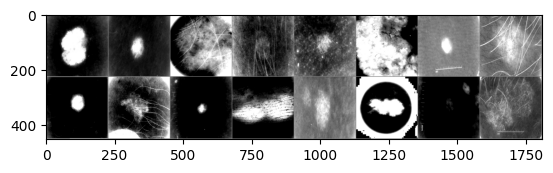

Predicted:  1 0 1 0 1 1 0 0


In [31]:


def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Visualize some test images and their predictions
net.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Make predictions
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(8)))


## ****Grad-CAM** (Gradient-weighted Class Activation Mapping):**

The provided code defines a **Grad-CAM** (Gradient-weighted Class Activation Mapping) implementation for visualizing and interpreting the regions of an image that contribute to a model's prediction. Below, I explain the functionality and the steps involved:

### **GradCAM Class**

1. **Initialization (`__init__`)**:
   - The class is initialized with the model and the target layer from which the activations will be extracted.
   - **Hooks** are registered for both the forward pass (activations) and the backward pass (gradients).

2. **`save_activation` Method**:
   - This method is used as a hook during the forward pass to capture the activations from the target layer.
   - The activations are stored in `self.activations`.

3. **`save_gradient` Method**:
   - This method is used as a hook during the backward pass to capture the gradients (i.e., the backpropagated gradients of the target class with respect to the activations).
   - The gradients are stored in `self.gradients`.

4. **`__call__` Method**:
   - **Forward Pass**: The model performs a forward pass and calculates the output probabilities.
   - If no class index is provided (`class_idx`), the method selects the class with the highest probability.
   - **Backward Pass**: A one-hot tensor is created for the selected class, and the gradients are backpropagated with respect to this class. This generates the gradient information.
   - The gradients are averaged over the spatial dimensions to get the weights for each activation map.
   - **CAM Calculation**: The weights are multiplied with the corresponding activation maps, and the resulting weighted sum is passed through a ReLU activation to obtain the final CAM.
   - **Normalization**: The CAM is normalized to the range \([0, 1]\).

### **`visualize_cam` Function**

This function is used to overlay the generated **Grad-CAM** heatmap on top of the input image for visualization.

1. **Convert Image**: The input image (which can be a PIL image or a NumPy array) is converted to a NumPy array if it's not already in that format.
   
2. **Normalize and Resize CAM**: The Grad-CAM heatmap is resized to match the dimensions of the input image and normalized if needed (ensuring the values are within the range \([0, 1]\)).

3. **Generate Heatmap**: The **JET colormap** is applied to the CAM to create a heatmap that visually highlights the important areas of the image.
   
4. **Combine Image and Heatmap**: The heatmap is blended with the original image using `cv2.addWeighted`, allowing the regions highlighted by the CAM to be superimposed onto the image for easy visualization.

### **Usage Example**

Here’s how you might use this `GradCAM` class and `visualize_cam` function:

### Key Notes:

1. **Target Layer**: The `target_layer` (such as `model.layer4[1]` in the example) is the convolutional layer from which the activations will be extracted. The choice of layer depends on the model architecture and the level of abstraction you want to visualize.
   
2. **Image Preparation**: The input image needs to be preprocessed (e.g., normalization, resizing) as required by the model. You might need to adjust the image format based on whether you're using a single image or a batch.

3. **Grad-CAM Visualization**: The visualization is produced by combining the original image with the heatmap, making it easy to see which areas of the image contribute to the model’s decision.

### Possible Extensions:
- **Class Activation Map for Multiple Classes**: You can loop through all classes and generate separate CAMs for each class to compare their influence.
- **Improved Visualization**: Additional techniques like **guided backpropagation** or **integrated gradients** can be combined with Grad-CAM for more interpretable visualizations.

Let me know if you need further help!

In [65]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def __call__(self, x, class_idx=None):
        # Forward pass
        self.model.eval()
        output = self.model(x)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3))
        
        # Weight the activations
        cam = torch.zeros(self.activations.shape[2:], device=self.activations.device)
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        
        return cam.detach()

def visualize_cam(image, cam):
    # Convert PIL Image to numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image
    
    # Convert CAM to numpy array if it isn't already
    if torch.is_tensor(cam):
        cam = cam.cpu().numpy()
    
    # Normalize CAM to 0-1 range if needed
    if cam.max() > 1:
        cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    # Ensure cam is the same size as the input image
    cam_resized = cv2.resize(cam, (image_np.shape[1], image_np.shape[0]))
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    
    # Convert RGB to BGR if necessary (OpenCV uses BGR)
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    
    # Ensure both images have the same number of channels
    if len(image_np.shape) != len(heatmap.shape):
        if len(image_np.shape) == 2:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)
    
    # Now combine them
    result = cv2.addWeighted(image_np, 0.7, heatmap, 0.3, 0)
    
    return result

## **Grad-CAM Visualization for Melanoma Classification**

This script processes a set of random test images, generates Grad-CAM heatmaps for each, and visualizes the results. The following steps are performed:

1. **Loading and Preprocessing:**
   - Images are loaded from directories (`malignant` and `benign`), resized, converted to grayscale, and normalized.
   
2. **Grad-CAM Generation:**
   - The model performs a forward pass and calculates gradients for the target class using the `GradCAM` class.
   - The Grad-CAM heatmap is generated by weighting the activations with the gradients.

3. **Visualization:**
   - The original image and the Grad-CAM heatmap are displayed side by side for comparison.

#### **Code Execution:**

1. **Loading Image Paths:**

2. **Random Sampling:**

3. **Image Preprocessing and Grad-CAM Calculation:**

4. **Grad-CAM Visualization:**
  
5. **Plotting Results:**

This script demonstrates how to visualize the areas of an image that contribute the most to the model’s prediction, providing interpretability for the melanoma classification model. By overlaying the Grad-CAM heatmap, you can understand which regions of the image the model focuses on, helping in model transparency and trust.

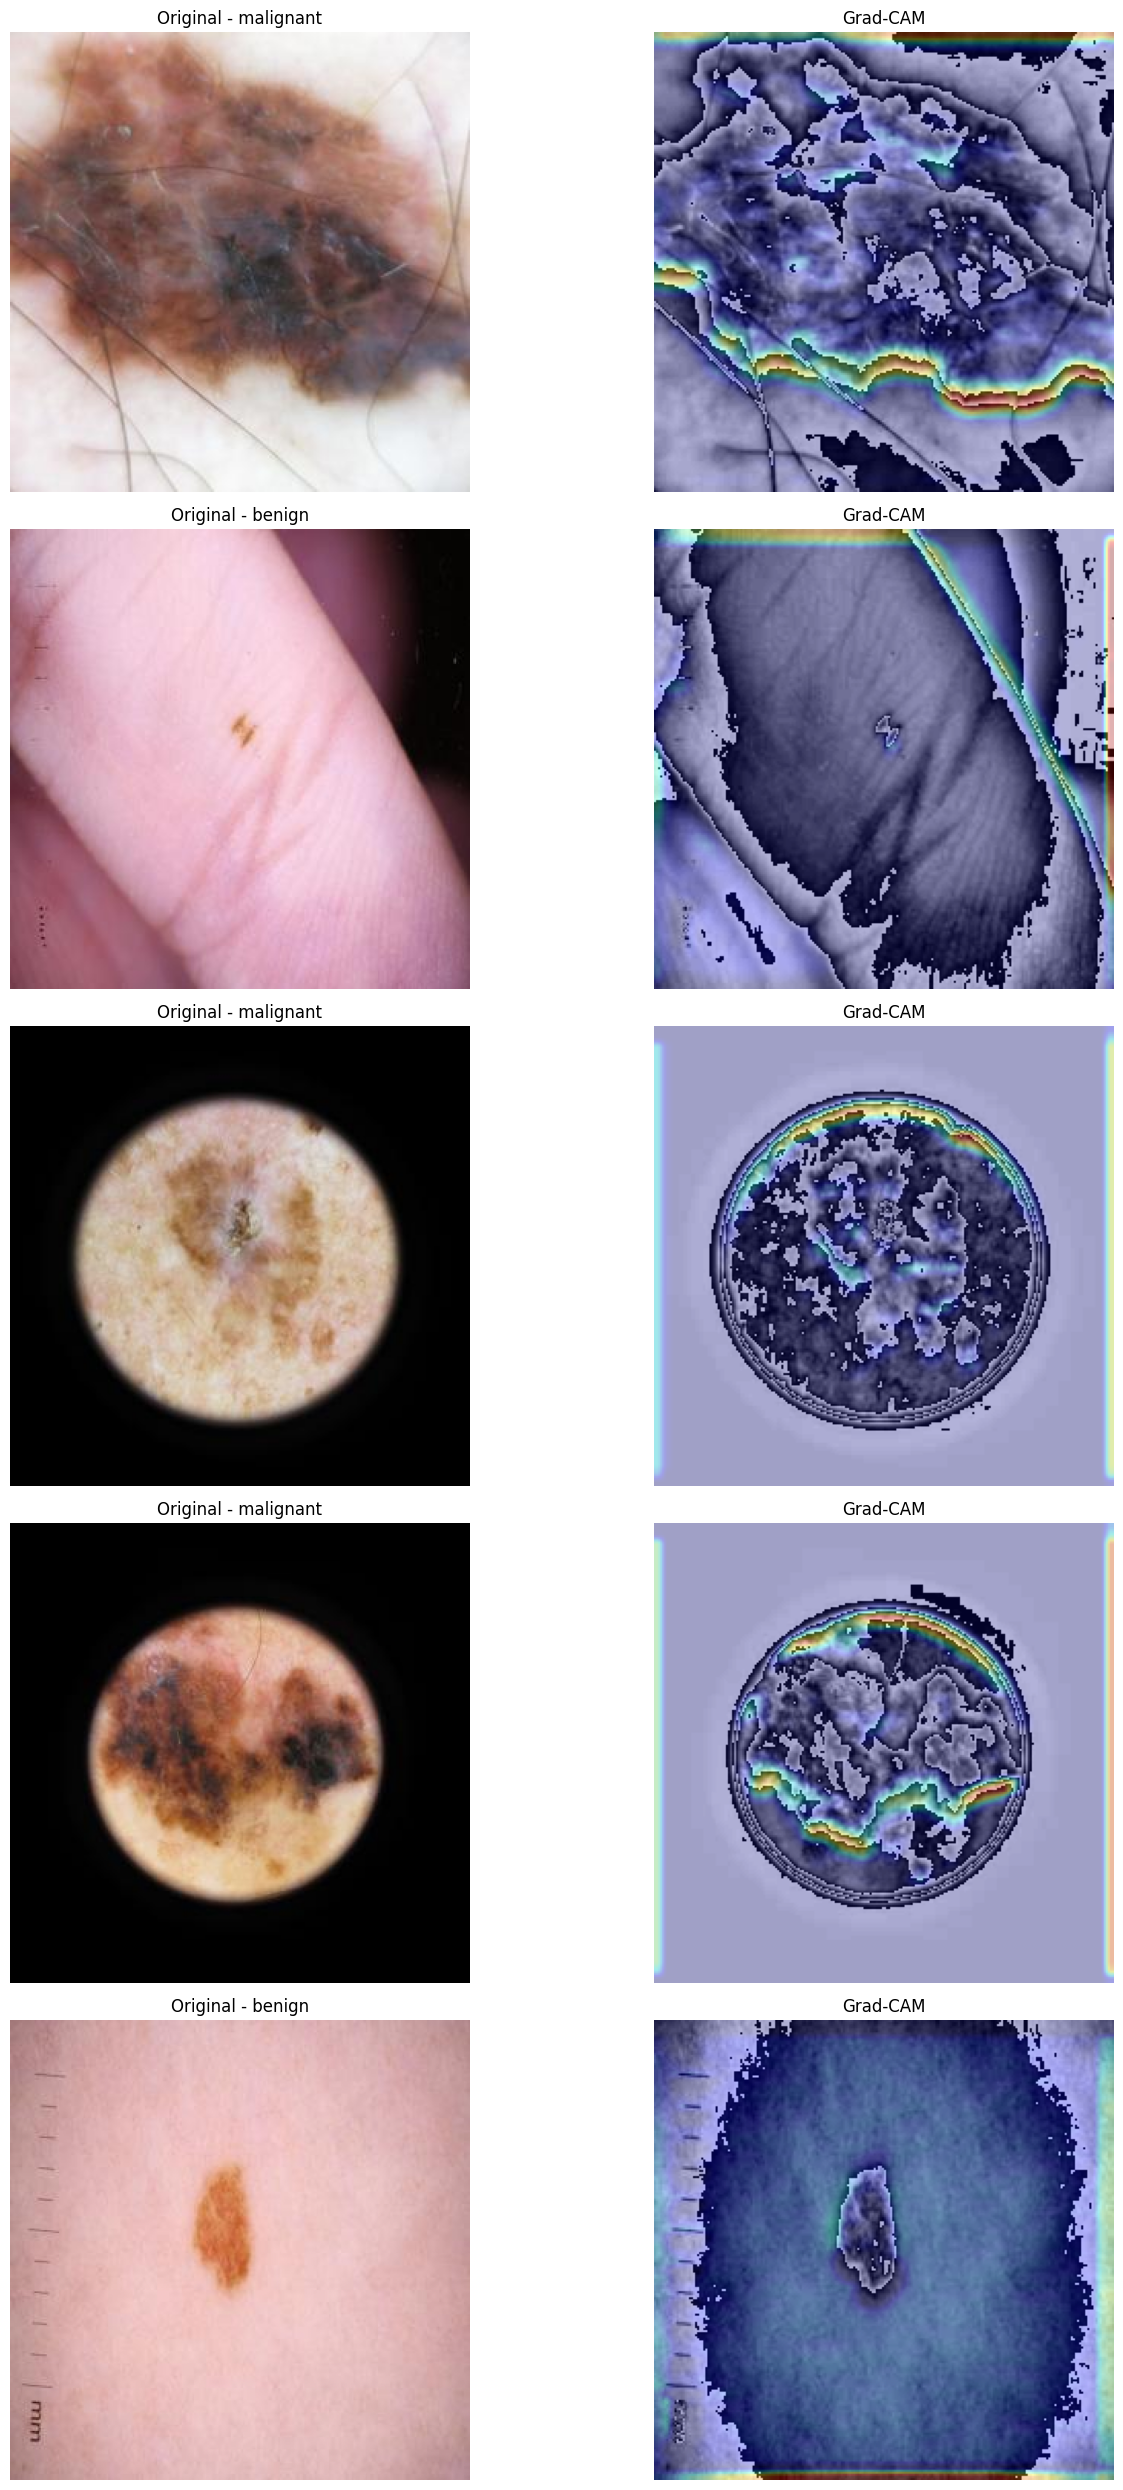

In [73]:
 # Define directories
img_dir_malignant = '/kaggle/working/melanoma_cancer_dataset/test/malignant'
img_dir_benign = '/kaggle/working/melanoma_cancer_dataset/test/benign'

# Get all image paths
malignant_paths = list(Path(img_dir_malignant).glob('*.jpg'))
benign_paths = list(Path(img_dir_benign).glob('*.jpg'))
all_img_paths = malignant_paths + benign_paths

# Get random samples
num_samples = 5
random_img_paths = random.sample(all_img_paths, min(num_samples, len(all_img_paths)))

plt.figure(figsize=(15, 5*num_samples))

for idx, path in enumerate(random_img_paths):
    # Load and preprocess image
    pil_image = Image.open(path).convert('RGB')

    
    # Define transforms
    
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229]),  # Adjust normalization for grayscale  
    ])
    
    # Transform and add batch dimension
    
    input_tensor = transform(pil_image).unsqueeze(0)
    
    # Move everything to GPU if available
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    grad_cam = GradCAM(model, target_layer)
    input_tensor = input_tensor.to(device)
    # Generate CAM
    cam = grad_cam(input_tensor)
    # Visualize
    input_image = transforms.ToPILImage()(input_tensor.squeeze(0).cpu())
    result = visualize_cam(input_image, cam)

     # Plot original and Grad-CAM
    plt.subplot(num_samples, 2, 2*idx + 1)
    plt.imshow(pil_image)
    plt.title(f'Original - {path.parent.name}')
    plt.axis('off')
    
    plt.subplot(num_samples, 2, 2*idx + 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [81]:
dummy_input = torch.randn(1, 1, 224, 224).to(device)  # Batch size = 1, 1 channel (grayscale), 224x224 image

# Forward pass to get the output of the model
output = model(dummy_input).to(device)

# Generate a visualization of the model's computation graph
dot = make_dot(output, params=dict(model.named_parameters()))

# Render and display the visualization in Jupyter Notebook
dot.render("model_architecture", format="png")  # Saves the visualization as PNG
dot.view()  # Displays the image in the notebook


'model_architecture.pdf'

In [82]:
model


MelanomaCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [85]:

# Assuming you have your model loaded as 'model'
# Create a dummy input tensor to pass through the model (224x224 grayscale image)
dummy_input = torch.randn(1, 1, 224, 224).to(device)  # Batch size = 1, 1 channel (grayscale), 224x224 image

# Forward pass to get the output of the model
output = net(dummy_input).to(device)

# Generate a visualization of the model's computation graph
dot = make_dot(output, params=dict(net.named_parameters()))

# Render and display the visualization in Jupyter Notebook
dot.render("model_architecture1", format="png")  # Saves the visualization as PNG
dot.view()  # Displays the image in the notebook

'model_architecture1.pdf'

![](ConnectforMore.png)